# Initialize notebook

In [1]:
# Import libraries
import math
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import mean_squared_error
import time
from operator import is_not
from functools import partial
import statistics
from tqdm import tqdm
from scipy.optimize import curve_fit
import pickle
from functools import reduce

In [2]:
# Constants
#KITTI_DATASET = '/media/javier/HDD_linux/KITTI_dataset/training/'
KITTI_DATASET = '/media/robesafe/SSD_SATA/KITTI_DATASET/'

# Load dataframe

In [3]:
df = pd.read_csv (KITTI_DATASET+'kitti_gt.csv')
df_train = pd.read_csv (KITTI_DATASET+'kitti_train_gt.csv')
df_val = pd.read_csv (KITTI_DATASET+'kitti_val_gt.csv')

In [4]:
df

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian        0.0       0.0  -0.20  712.40  143.00   
1          1   0         Car        0.0       0.0   1.85  387.63  181.54   
2          1   1     Cyclist        0.0       3.0  -1.65  676.60  163.95   
3          2   0         Car        0.0       0.0  -1.67  657.39  190.13   
4          3   0         Car        0.0       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
34851   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
34852   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
34853   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
34854   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
34855   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
34851  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
34852  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
34853  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
34854  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
34855  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
34851  19.776334         72.60       167.73       0.29   
34852  27.044846         44.10       135.03      -0.26   
34853  29.623654         39.39       112.78      -0.23   
34854  32.083610         34.52        46.69       0.06   
34855  47.074042         23.02        27.09       0.03   

       incomplete_2d_horizontal  incomplete_2d_bottom  
0                         False                 False  
1                         False                 False  
2                         False                 False  
3                         False                 False  
4                         False                 False  
...                         ...                   ...  
34851                     False                 False  
34852                     False                 False  
34853                     False                 False  
34854                     False                 False  
34855                     False                 False  

[34856 rows x 23 columns]

In [5]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27993   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27994   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27995   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27996   5983  11         Car       0.00       2.0  -1.57  594.88  172.76   
27997   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27993  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27994  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27995   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27996  633.46  207.96    1.52   1.67    3.61   0.16  1.54  33.23 -1.56   
27997   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27993  25.510956         48.09        57.82       0.11   
27994  43.498770         24.21        31.43       0.06   
27995  13.748476        101.47        95.57      -0.72   
27996  33.266050         35.20        38.58       0.01   
27997  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  
0                         False                 False  
1                         False                 False  
2                         False                 False  
3                         False                 False  
4                         False                 False  
...                         ...                   ...  
27993                     False                 False  
27994                     False                 False  
27995                      True                 False  
27996                     False                 False  
27997                      True                 False  

[27998 rows x 23 columns]

In [6]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6853   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6854   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6855   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6856   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6857   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6853  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6854  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6855  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6856  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6857  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6853  19.776334         72.60       167.73       0.29   
6854  27.044846         44.10       135.03      -0.26   
6855  29.623654         39.39       112.78      -0.23   
6856  32.083610         34.52        46.69       0.06   
6857  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  
0                        False                 False  
1                        False                 False  
2                        False                 False  
3                        False                 False  
4                        False                 False  
...                        ...                   ...  
6853                     False                 False  
6854                     False                 False  
6855                     False                 False  
6856                     False                 False  
6857                     False                 False  

[6858 rows x 23 columns]

# Point Cloud projection

In [17]:
def get_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    binary = KITTI_DATASET+'velodyne/'+name+'.bin'
    with open(KITTI_DATASET+'calib/'+name+'.txt','r') as f:
        calib = f.readlines()

    # P2 (3 x 4) for left eye (intrinsic matrix in homogeneous coordinates)
    P2 = np.matrix([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3,4)
    R0_rect = np.matrix([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
    R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
    Tr_velo_to_cam = np.matrix([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

    # read raw data from binary
    scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))
    points = scan[:, 0:3] # lidar xyz (front, left, up)
    # TODO: use fov filter? 
    velo = np.insert(points,3,1,axis=1).T
    velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
    
    cam = P2 * R0_rect * Tr_velo_to_cam * velo
    
    cam = np.delete(cam,np.where(cam[2,:]<0)[1],axis=1)
    
    # get u,v,z
    cam[:2] /= cam[2,:]
    
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # filter point out of canvas
    u,v,z = cam
    u_out = np.logical_or(u<0, u>IMG_W)
    v_out = np.logical_or(v<0, v>IMG_H)
    outlier = np.logical_or(u_out, v_out)
    cam = np.delete(cam,np.where(outlier),axis=1)
    return cam

In [18]:
def show_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    cam = get_point_cloud_projected(image_id)
    # generate color map from depth
    u,v,z = cam
    plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
    plt.title(name)
    
    plt.show()

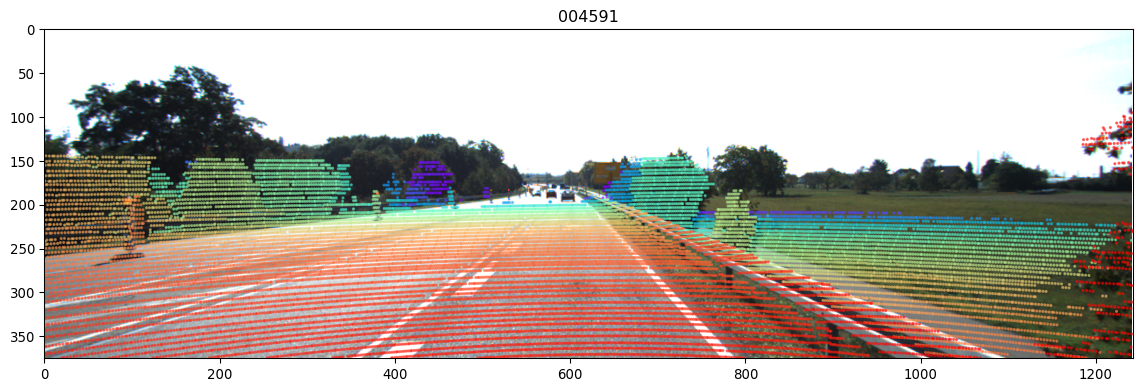

In [19]:
# Caso en el que la regresión no funcionaría correctamente
show_point_cloud_projected(4591)

# 2D bounding boxes

In [10]:
def get_bounding_boxes_2D(image_id):
    df_frame = df[df['frame'] == image_id]
    bbs = []
    for index, row in df_frame.iterrows():
        bb = (row['left'], row['top'], row['right'], row['bottom'])
        bbs.append(bb)
    return bbs

In [11]:
def show_bounding_boxes_2D(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    # draw bounding boxes
    bbs = get_bounding_boxes_2D(image_id)
    for bb in bbs:
        plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
    
    # plt.savefig(KITTI_DATASET+'projection/{name}.png',bbox_inches='tight')
    plt.show()

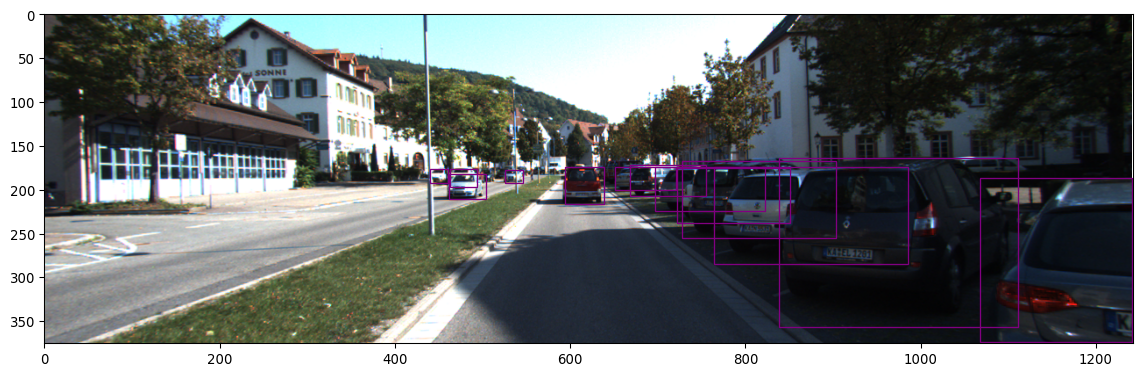

In [12]:
show_bounding_boxes_2D(500)

# 1st distance approximation approach

In [13]:
def get_gt_distance(image_id):
    df_frame = df_train[df_train['frame'] == image_id]
    distances = []
    for index, row in df_frame.iterrows():
        distances.append(row['distance'])
    return distances

In [14]:
def get_distance_pc_projection(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    bbs_distance = [[],[]]
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            bbs_distance[0].append(bb)
            bbs_distance[1].append(distance)
        else:
            bbs_distance[0].append(bb)
            bbs_distance[1].append(None)
    
    return bbs_distance

In [15]:
get_distance_pc_projection(1000)

[[(798.93, 169.95, 1060.55, 250.42),
  (561.02, 184.64, 587.94, 208.4),
  (468.53, 187.25, 501.75, 210.97)],
 [14.171984473285315, 47.58936221146112, 45.1118412020316]]

In [16]:
def show_image_distance(image_id, bbs_distance):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    
    # show image
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    # draw bounding boxes
    gt_distances = get_gt_distance(image_id)
    if(len(bbs_distance[0]) > 0):
        bbs = bbs_distance[0]
        distances = bbs_distance[1]
        for bb, distance, gt_distance in zip(bbs, distances, gt_distances):
            plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
            plt.text(bb[0],bb[1],str(round(distance,2))+"m",color='green')
            plt.text(bb[0],bb[1]+10,str(round(gt_distance,2))+"m",color='red')
            print(distance)
            print(gt_distance)
            print("---")
        
    plt.show()

14.171984473285315
15.90967944365945
---
47.58936221146112
49.6786282016724
---
45.1118412020316
48.01710320292136
---


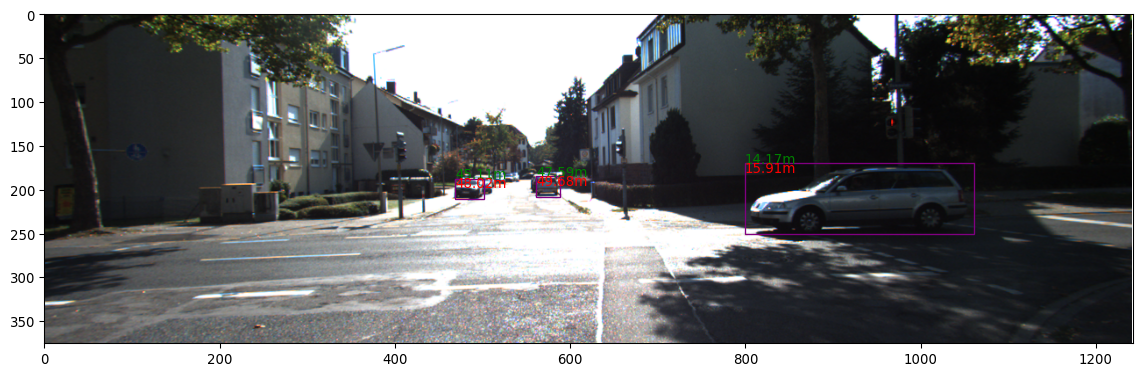

In [17]:
image_id = 1000
show_image_distance(image_id, get_distance_pc_projection(image_id))

## MSE KITTI difficulties

In [18]:
df_train['distance_approx'] = reduce(lambda a,b: a+b, list(map(lambda frame: get_distance_pc_projection(frame)[1], df_train['frame'].unique())))
df_train['distance_error'] = df_train['distance'] - df_train['distance_approx']
df_val['distance_approx'] = reduce(lambda a,b: a+b, list(map(lambda frame: get_distance_pc_projection(frame)[1], df_val['frame'].unique())))
df_val['distance_error'] = df_val['distance'] - df_val['distance_approx']

In [19]:
def define_difficulty(row):
    height = row['bottom'] - row['top']
    occlusion = row['occluded']
    truncation = row['truncated']
    if(height >= 40 and occlusion == 0 and truncation <= 0.15):
        return 0
    elif(height >= 25 and occlusion <= 1 and truncation <= 0.3):
        return 1
    elif(height >= 25 and occlusion <= 2 and truncation <= 0.5):
        return 2
    else:
        return 3

In [20]:
df_val['difficulty'] = df_val.apply(lambda row: define_difficulty(row), axis=1)
df_val = df_val.dropna()

In [21]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6853   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6854   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6855   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6856   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6857   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6853  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6854  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6855  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6856  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6857  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6853  19.776334         72.60       167.73       0.29   
6854  27.044846         44.10       135.03      -0.26   
6855  29.623654         39.39       112.78      -0.23   
6856  32.083610         34.52        46.69       0.06   
6857  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
0                        False                 False        33.951394   
1                        False                 False        46.418030   
2                        False                 False        49.005706   
3                        False                 False        49.852558   
4                        False                 False        51.133280   
...                        ...                   ...              ...   
6853                     False                 False        15.919959   
6854                     False                 False        23.765591   
6855                     False                 False        25.429258   
6856                     False                 False        30.272493   
6857                     False                 False        45.628701   

      distance_error  difficulty  
0           1.282255           1  
1           0.850756           1  
2           1.840128           1  
3           2.859517           1  
4           2.450776           3  
...              ...         ...  
6853        3.856376           2  
6854        3.279255           1  
6855        4.194396           2  
6856        1.811117           1  
6857        1.445341           3  

[6856 rows x 26 columns]

In [22]:
difficulties = [0, 1, 2, 3]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard", "All"]

print("################################", end="\n\n")

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        start_time = time.time()
        mse = mean_squared_error(df_difficulty['distance'].tolist(),
                                 df_difficulty['distance_approx'].tolist())
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mse))

    print("################################", end="\n\n")

################################

--- 0.00045180320739746094 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 4.084804688485108

--- 0.00025153160095214844 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 7.133609402961737

--- 0.0002727508544921875 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 3.3556409600220554

################################

--- 0.0004754066467285156 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 15.758954150901964

--- 0.00024771690368652344 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 11.968506306083446

--- 0.0002887248992919922 seconds to calculate MSE, Moderate difficulty, Pedestrian c

# 2nd distance approximation approach

In [23]:
def get_intersection_between_rectangles(bb1, bb2):
    """
    bb: [left, top, right, bottom]
    """
    left = max(bb1[0], bb2[0])
    top = max(bb1[1], bb2[1])
    right = min(bb1[2], bb2[2])
    bottom = min(bb1[3], bb2[3])
    if left > right:
        return None
    if top > bottom:
        return None
    return [left, top, right, bottom]

In [24]:
def get_point_cloud_projected_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    n_bbs = len(bbs)
    for i in range(n_bbs):
        for j in range(i+1, n_bbs):
            intersection = get_intersection_between_rectangles(bbs[i], bbs[j])
            if (intersection != None):
                filter_intersection = (intersection[0] < projected_pc[0,:]) &\
                                      (intersection[1] < projected_pc[1,:]) &\
                                      (projected_pc[0,:] < intersection[2]) &\
                                      (projected_pc[1,:] < intersection[3])
                
                projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                               projected_pc[1,:][~filter_intersection],\
                                               projected_pc[2,:][~filter_intersection]), axis=0)
                
                
    return projected_pc

In [25]:
def show_point_cloud_projected_without_intersections(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    cam = get_point_cloud_projected_without_intersections(image_id)
    # generate color map from depth
    u,v,z = cam
    plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
    plt.title(name)
    
    # draw bounding boxes
    bbs = get_bounding_boxes_2D(image_id)
    for bb in bbs:
        plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
    
    plt.show()

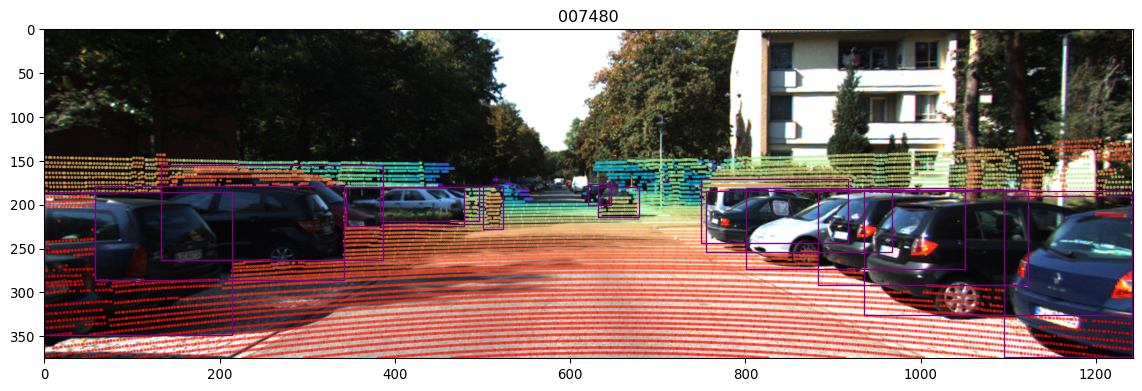

In [26]:
# Difficult situation (37)
show_point_cloud_projected_without_intersections(7480)

In [27]:
def get_point_cloud_projected_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    n_bbs = len(bbs)
    for i in range(n_bbs):
        for j in range(i+1, n_bbs):
            intersection = get_intersection_between_rectangles(bbs[i], bbs[j])
            if (intersection != None):
                filter_intersection = (intersection[0] < projected_pc[0,:]) &\
                                      (intersection[1] < projected_pc[1,:]) &\
                                      (projected_pc[0,:] < intersection[2]) &\
                                      (projected_pc[1,:] < intersection[3])
                
                projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                               projected_pc[1,:][~filter_intersection],\
                                               projected_pc[2,:][~filter_intersection]), axis=0)
                
                
    return projected_pc

In [28]:
# Function to execute the regression by height model
def approximate_distance_height(type_name, top, bottom, bb_complete, model):
    height = bottom - top
    if type_name == 'Car':
        if bb_complete:
            f = model.car.bb_complete.function
            return f(height, *model.car.bb_complete.variables)
        else:
            f = model.car.bb_incomplete.function
            return f(height, *model.car.bb_incomplete.variables)
    elif type_name == 'Pedestrian':
        f = model.pedestrian.function
        return f(height, *model.pedestrian.variables)
    elif type_name == 'Cyclist':
        f = model.cyclist.function
        return f(height, *model.cyclist.variables)
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")

In [29]:
# Object to open the pkl file
def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c

class Regression_model:
    def __init__(self, function, variables):
        self.function = function
        self.variables = variables
    def __str__(self):
        return "function = %s, variables = %s"%(self.function, self.variables)

class Regression_model_class:
    def __init__(self, model_car, model_pedestrian, model_cyclist):
        self.car = model_car
        self.pedestrian = model_pedestrian
        self.cyclist = model_cyclist
    def __str__(self):
        return "car: {%s} \npedestrian: {%s} \ncyclist: {%s}\n"%(self.car, self.pedestrian, self.cyclist)
        
class Regression_model_bb:
    def __init__(self, bb_complete, bb_incomplete):
        self.bb_complete = bb_complete
        self.bb_incomplete = bb_incomplete
    def __str__(self):
        return "bb_complete: {%s},\nbb_incomplete: {%s}\n"%(self.bb_complete, self.bb_incomplete)

In [30]:
# Approximate distance by removing the points of the previous vehicles
def get_distance_pc_projection_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = df[df['frame'] == image_id]['type'].tolist()
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
    
    bbs_distance = [[],[]]
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                               not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        
    # Iterate over bb
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            bbs_distance[0].append(bb)
            bbs_distance[1].append(distance)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [31]:
get_distance_pc_projection_without_intersections(1)

[[(676.6, 163.95, 688.98, 193.93), (387.63, 181.54, 423.81, 203.12)],
 [45.75585182809419, 56.809068486478445]]

In [32]:
frame_list, left_list, top_list, right_list, bottom_list, distance_approx_list = [], [], [], [], [], []
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
# Iterate over frames
for frame in df['frame'].unique():
    # Get distance approimation using 2nd method
    bbs2D, distance_approx = get_distance_pc_projection_without_intersections(frame)
    # Fill columns data in lists
    frame_list.extend(len(distance_approx)*[frame])
    ## Iterate over bbs2D
    for bb2D in bbs2D:
        left_list.append(bb2D[0])
        top_list.append(bb2D[1])
        right_list.append(bb2D[2])
        bottom_list.append(bb2D[3])
    distance_approx_list.extend(distance_approx)
    
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = ['frame','left','top','right','bottom','distance_approx_2'],
                         data = list(zip(frame_list, left_list, top_list, right_list, bottom_list, distance_approx_list)))

100%|█████████▉| 7478/7481 [02:39<00:00, 51.03it/s]

In [33]:
df_approx

frame    left     top   right  bottom  distance_approx_2
0          0  712.40  143.00  810.73  307.92          12.379818
1          1  676.60  163.95  688.98  193.93          45.755852
2          1  387.63  181.54  423.81  203.12          56.809068
3          2  657.39  190.13  700.07  223.39          33.731449
4          3  614.24  181.78  727.31  284.77          12.274350
...      ...     ...     ...     ...     ...                ...
34007   7480  501.01  178.40  523.53  228.03          24.206338
34008   7480  344.07  180.05  479.10  224.15          25.222057
34009   7480  382.70  179.71  495.48  219.10          29.558852
34010   7480  631.71  179.85  678.40  214.37          30.272493
34011   7480  619.92  176.90  647.01  199.92          46.099539

[34012 rows x 6 columns]

In [34]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])

In [35]:
df_train['distance_error_2'] = df_train['distance'] - df_train['distance_approx_2']
df_val['distance_error_2'] = df_val['distance'] - df_val['distance_approx_2']

In [36]:
df_val[df_val['frame'] == 7480]

frame  id     type  truncated  occluded  alpha     left     top  \
6687   7480   0      Car       0.60       3.0  -2.42     0.00  185.93   
6688   7480   1      Car       0.00       1.0  -2.73    57.68  178.66   
6689   7480   2      Car       0.00       2.0   0.40   133.20  154.23   
6690   7480   3  Cyclist       0.00       0.0   1.66   501.01  178.40   
6691   7480   4      Car       0.84       0.0  -0.75  1094.88  190.09   
6692   7480   5      Car       0.19       3.0  -0.57   934.82  184.38   
6693   7480   6      Car       0.00       2.0  -0.56   882.79  183.25   
6694   7480   7      Car       0.00       2.0   2.68   800.16  181.42   
6695   7480   8      Car       0.00       2.0  -0.39   755.13  184.19   
6696   7480   9      Car       0.00       2.0  -0.33   749.78  170.88   
6697   7480  10      Car       0.00       1.0  -2.90   344.07  180.05   
6698   7480  11      Car       0.00       2.0  -2.91   382.70  179.71   
6699   7480  12      Car       0.00       0.0  -1.69   631.71  179.85   
6700   7480  13      Car       0.00       2.0  -1.62   619.92  176.90   

        right  bottom  height  width  length     x     y      z    ry  \
6687   214.05  348.86    1.56   1.57    4.37 -6.96  1.73   7.83 -3.13   
6688   341.72  285.91    1.65   1.68    3.88 -6.88  1.77  12.36  3.05   
6689   386.37  263.44    2.08   1.80    4.37 -7.14  1.75  14.97 -0.04   
6690   523.53  228.03    1.59   0.58    1.69 -3.29  1.78  24.09  1.53   
6691  1241.00  374.00    1.54   1.75    3.36  6.04  1.68   5.65  0.04   
6692  1241.00  326.25    1.48   1.52    3.33  5.79  1.63   8.47  0.01   
6693  1122.39  291.95    1.50   1.58    2.81  5.88  1.68  11.09 -0.08   
6694  1050.12  273.59    1.57   1.68    3.97  5.77  1.75  13.60  3.08   
6695   967.47  253.54    1.44   1.65    4.26  5.60  1.72  16.48 -0.07   
6696   917.51  243.48    1.77   1.69    3.82  5.72  1.75  18.85 -0.04   
6697   479.10  224.15    1.49   1.59    4.44 -7.12  1.78  26.03  3.12   
6698   495.48  219.10    1.48   1.63    4.10 -6.79  1.78  28.78 -3.14   
6699   678.40  214.37    1.41   1.56    4.08  1.90  1.74  31.98 -1.63   
6700   647.01  199.92    1.43   1.58    3.37  1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
6687  10.618070        162.93       214.05      -0.71   
6688  14.256118        107.25       284.04      -0.50   
6689  16.677620        109.21       253.17      -0.44   
6690  24.378692         49.63        22.52      -0.13   
6691   8.439579        183.91       146.12       0.79   
6692  10.388547        141.87       306.18       0.58   
6693  12.664316        108.70       239.60       0.48   
6694  14.876673         92.17       249.96       0.40   
6695  17.490249         69.35       212.34       0.32   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
6687                      True                 False         7.451955   
6688                     False                 False        11.739119   
6689                     False                 False        14.251668   
6690                     False                 False        24.206338   
6691                      True                 False         6.345732   
6692                      True                 False         8.675669   
6693                     False                 False        10.713277   
6694                     False                 False        13.007971   
6695                     False                 False        15.595589   
6696                     False                 False        15.919959   
6697                     False                 False        23.765591   
6698                     False                 False        25.429258   
6699     

### MSE of the distance with the 2nd method by KITTI difficulties and classes

In [37]:
def define_difficulty(row):
    height = row['bottom'] - row['top']
    occlusion = row['occluded']
    truncation = row['truncated']
    if(height >= 40 and occlusion == 0 and truncation <= 0.15):
        return 0
    elif(height >= 25 and occlusion <= 1 and truncation <= 0.3):
        return 1
    elif(height >= 25 and occlusion <= 2 and truncation <= 0.5):
        return 2
    else:
        return 3

In [38]:
df_train['difficulty'] = df_train.apply(lambda row: define_difficulty(row), axis=1)
df_val['difficulty'] = df_val.apply(lambda row: define_difficulty(row), axis=1)

In [39]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6696   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6697   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6698   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6699   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6700   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6696  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6697  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6698  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6699  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6700  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
0                        False                 False        33.951394   
1                        False                 False        46.418030   
2                        False                 False        49.005706   
3                        False                 False        49.852558   
4                        False                 False        51.133280   
...                        ...                   ...              ...   
6696                     False                 False        15.919959   
6697                     False                 False        23.765591   
6698                     False                 False        25.429258   
6699                     False                 False        30.272493   
6700                     False                 False        45.628701   

      distance_error  difficulty  distance_approx_2  distance_error_2  
0           1.282255           1          33.951394          1.282255  
1           0.850756           1          46.418030          0.850756  
2           1.840128           1          49.005706          1.840128  
3           2.859517           1          50.347864          2.364212  
4           2.450776           3          51.782106          1.801950  
...              ...         ...                ...               ...  
6696        3.856376           2          19.033945          0.742389  
6697        3.279255           1          25.222057          1.822789  
6698        4.1943

In [40]:
print(statistics.mean(list(map(lambda x: x**2, df_val['distance_error'].tolist()))))
print(statistics.mean(list(map(lambda x: x**2, df_val['distance_error_2'].tolist()))))

32.18654580031961
28.322650170105323


In [41]:
df_val[df_val['difficulty'] == 0]

frame  id        type  truncated  occluded  alpha     left     top  \
8      5985   2  Pedestrian        0.0       0.0  -2.17  1114.66  149.76   
10     5986   0         Car        0.0       0.0  -1.57   571.25  172.20   
11     5986   1         Car        0.0       0.0  -1.39   423.14  169.44   
15     5987   1         Car        0.0       0.0  -1.20   540.15  178.22   
17     5988   2  Pedestrian        0.0       0.0   1.30   650.99  143.91   
...     ...  ..         ...        ...       ...    ...      ...     ...   
6676   7476   1     Cyclist        0.0       0.0  -1.60   597.42  172.94   
6679   7476   4         Car        0.0       0.0  -2.91   353.53  184.98   
6680   7477   0  Pedestrian        0.0       0.0  -2.68   220.45  144.35   
6684   7479   2         Car        0.0       0.0   2.06   498.89  186.74   
6690   7480   3     Cyclist        0.0       0.0   1.66   501.01  178.40   

        right  bottom  height  width  length     x     y      z    ry  \
8     1186.84  260.84    1.70   0.48    0.87  8.55  1.35  11.49 -1.55   
10     618.16  214.96    1.60   1.76    3.84 -0.56  1.10  29.11 -1.59   
11     501.32  227.29    1.78   1.81    4.32 -4.87  1.28  24.47 -1.58   
15     623.61  218.76    1.32   1.48    4.44 -0.94  1.52  25.90 -1.24   
17     717.53  292.49    1.77   0.66    1.00  0.91  1.33   9.00  1.40   
...       ...     ...     ...    ...     ...   ...   ...    ...   ...   
6676   616.59  220.94    1.71   0.63    2.12 -0.16  1.73  26.91 -1.61   
6679   463.17  226.01    1.41   1.54    3.60 -7.36  1.88  26.42  3.10   
6680   289.12  301.68    1.94   0.76    1.23 -4.61  1.50   9.18 -3.13   
6684   759.60  333.70    1.46   1.74    3.99  0.44  1.67   9.57  2.10   
6690   523.53  228.03    1.59   0.58    1.69 -3.29  1.78  24.09  1.53   

       distance  height_image  width_image  theta_ray  \
8     14.385587        111.08        72.18       0.62   
10    29.136158         42.76        46.91      -0.02   
11    24.982718         57.85        78.18      -0.19   
15    25.961587         40.54        83.46      -0.04   
17     9.143140        148.58        66.54       0.10   
...         ...           ...          ...        ...   
6676  26.966027         48.00        19.17      -0.01   
6679  27.490369         41.03       109.64      -0.27   
6680  10.381450        157.33        68.67      -0.45   
6684   9.724577        146.96       260.71       0.04   
6690  24.378692         49.63        22.52      -0.13   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
8                        False                 False        11.915184   
10                       False                 False        27.324838   
11                       False                 False        22.761907   
15                       False                 False        24.758826   
17                       False                 False        10.501457   
...                        ...                   ...              ...   
6676                     False                 False        28.020938   
6679                     False                 False        25.942076   
6680                     False                 False        10.781629   
6684                     False                 False         9.779626   
6690                     False                 False        24.206338   

      distance_error  difficulty  distance_approx_2  distance_error_2  
8           2.470403           0          11.847613          2.537973  
10          1.811320           0          27.324838          1.811320  
11          2.220811           0          22.761907          2.220811  
15          1.202761           0          24.758826          1.202761  
17         -1.358318           0          10.501457         -1.358318  
...              ...         ...                ...               ...  
6676       -1.054912           0          28.020938         -1.054912  
6679        1.548293           0          25.936347          1.554022  
6680  

In [42]:
difficulties = [0, 1, 2, 3]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard", "All"]

print("################################", end="\n\n")

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        start_time = time.time()
        mse = mean_squared_error(df_difficulty['distance'].tolist(),
                                 df_difficulty['distance_approx_2'].tolist())
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mse))

    print("################################", end="\n\n")

################################

--- 0.0007588863372802734 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 5.1427257031238875

--- 0.00039005279541015625 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 7.106623989308742

--- 0.00041222572326660156 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 5.5569118670794415

################################

--- 0.001603841781616211 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 14.861047169726508

--- 0.0002963542938232422 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 19.73289719528847

--- 0.00035119056701660156 seconds to calculate MSE, Moderate difficulty, Pedestrian cl

# Closest distance to distance to the center

In [43]:
MDistanceE = df_train.apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
print("Mean distance error for all classes:")
print(MDistanceE, end="\n\n")

for distance in [20, 40, 60]:
    MDistanceE_distance = df_train[(distance-20 < df_train['distance_approx']) & (df_train['distance_approx'] < distance)].apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
    print("Mean distance error for all classes and %s < distance %s:" % (distance-20, distance))
    print(MDistanceE_distance, end="\n\n")
    
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_class = df_train[df_train['type'] == class_name].apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
    print("Mean distance error for %s class:" % (class_name))
    print(MDistanceE_class, end="\n\n")

Mean distance error for all classes:
0.25    1.078698
0.50    1.830799
0.75    3.460682
dtype: float64

Mean distance error for all classes and 0 < distance 20:
0.25    0.587920
0.50    1.615601
0.75    2.805072
dtype: float64

Mean distance error for all classes and 20 < distance 40:
0.25    1.452702
0.50    2.006594
0.75    4.737524
dtype: float64

Mean distance error for all classes and 40 < distance 60:
0.25    1.454355
0.50    1.954832
0.75    3.550078
dtype: float64

Mean distance error for Car class:
0.25    1.473290
0.50    2.016789
0.75    4.022626
dtype: float64

Mean distance error for Cyclist class:
0.25   -2.508990
0.50   -0.188313
0.75    0.449265
dtype: float64

Mean distance error for Pedestrian class:
0.25   -0.518916
0.50    0.278515
0.75    1.137189
dtype: float64



In [44]:
print(max(df_train['distance_approx']))
print(min(df_train['distance_approx']))

79.54851495763957
3.314993071731425


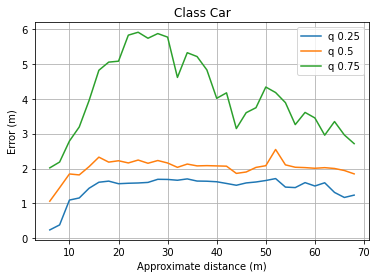

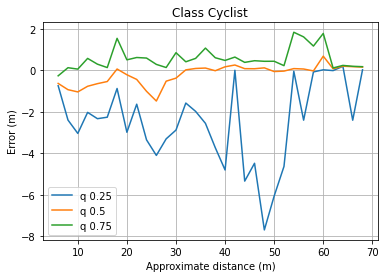

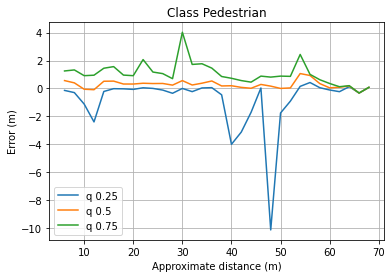

In [45]:
jump = 2
start = 5
end = 68
# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx']) & \
                                        (df_train['distance_approx'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_25 = list(map(lambda x: x.get(0.25), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_75 = list(map(lambda x: x.get(0.75), MDistanceE_distances))

    # Create plot
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_25)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_75)
    plt.legend(['q 0.25', 'q 0.5', 'q 0.75'])
    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')
    plt.grid()
    plt.show()

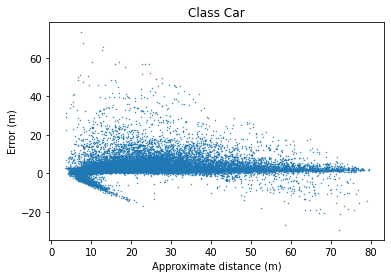

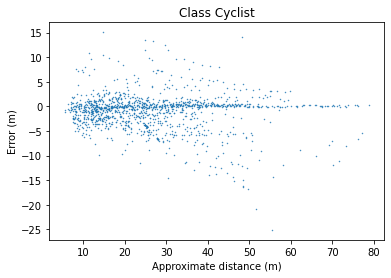

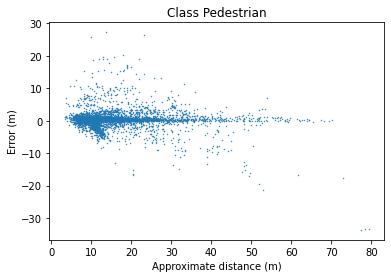

In [46]:
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_car = df_train[df_train['type'] == class_name]

    Y = df_train_car['distance_error'].values
    X = df_train_car['distance_approx'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.2)
    plt.show()

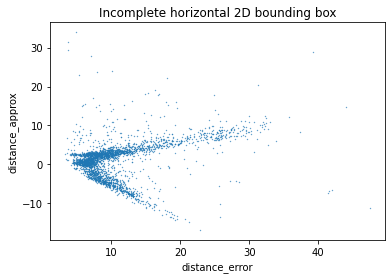

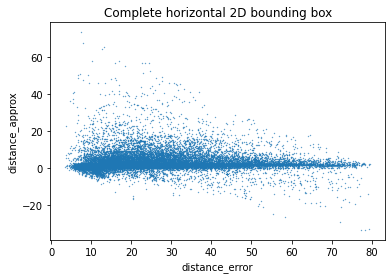

In [47]:
df_incomplete_2d_horizontal = df_train[df_train['incomplete_2d_horizontal'] == True]
df_complete_2d_horizontal = df_train[df_train['incomplete_2d_horizontal'] == False]

Y = df_incomplete_2d_horizontal['distance_error'].values
X = df_incomplete_2d_horizontal['distance_approx'].values
plt.title('Incomplete horizontal 2D bounding box')
plt.xlabel('distance_error')
plt.ylabel('distance_approx')
plt.scatter(X, Y, s=0.1)
plt.show()

Y = df_complete_2d_horizontal['distance_error'].values
X = df_complete_2d_horizontal['distance_approx'].values
plt.scatter(X, Y, s=0.1)
plt.title('Complete horizontal 2D bounding box')
plt.xlabel('distance_error')
plt.ylabel('distance_approx')
plt.show()

### Worst case

In [48]:
display(df_train[df_train['distance']-df_train['distance_approx'] > 60])

frame  id type  truncated  occluded  alpha    left     top   right  \
11339   2527   8  Car        0.0       0.0   1.78  599.29  173.88  621.72   
16668   3695   7  Car        0.0       1.0   1.80  603.71  172.54  626.59   
24387   5352   8  Car        0.0       1.0   1.75  599.19  177.40  621.62   
24873   5457   3  Car        0.0       2.0   1.84  398.19  178.10  423.88   

       bottom  height  width  length      x     y      z    ry   distance  \
11339  189.63    1.60   1.60    3.77   0.07  1.73  75.73  1.78  75.749790   
16668  186.65    1.52   1.65    4.10   0.60  1.52  80.80  1.81  80.816523   
24387  193.09    1.61   1.70    3.97   0.07  2.11  76.69  1.75  76.719053   
24873  197.13    1.92   1.58    3.93 -20.81  2.49  75.57  1.57  78.422453   

       height_image  width_image  theta_ray  incomplete_2d_horizontal  \
11339         15.75        22.43       0.00                     False   
16668         14.11        22.88       0.01                     False   
24387         15.69        22.43       0.00                     False   
24873         19.03        25.69      -0.27                     False   

       incomplete_2d_bottom  distance_approx  distance_error  \
11339                 False         8.030957       67.718833   
16668                 False         7.541695       73.274828   
24387                 False        12.689672       64.029381   
24873                 False        13.063902       65.358551   

       distance_approx_2  distance_error_2  difficulty  
11339           8.210726         67.539064           3  
16668           7.682149         73.134374           3  
24387          13.194057         63.524996           3  
24873          75.115025          3.307427           3

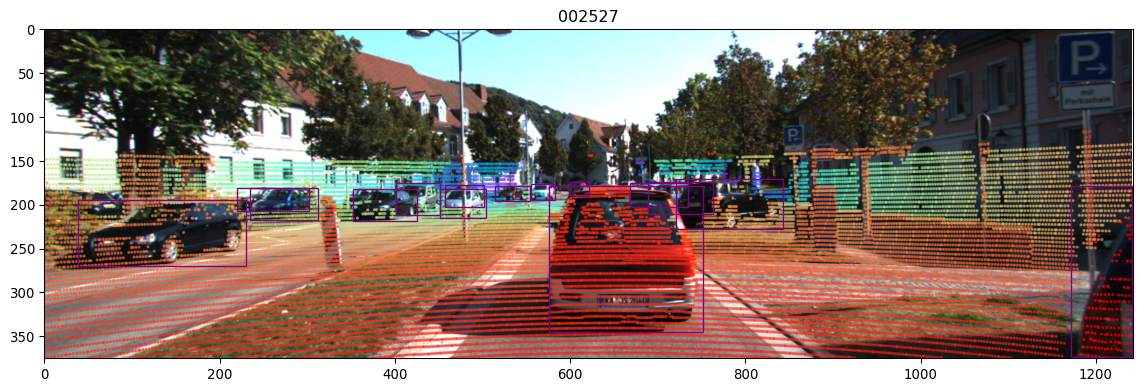

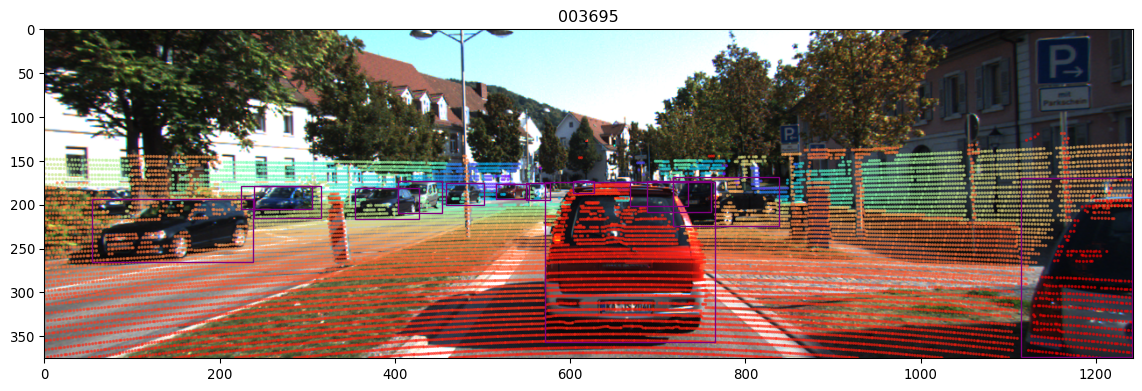

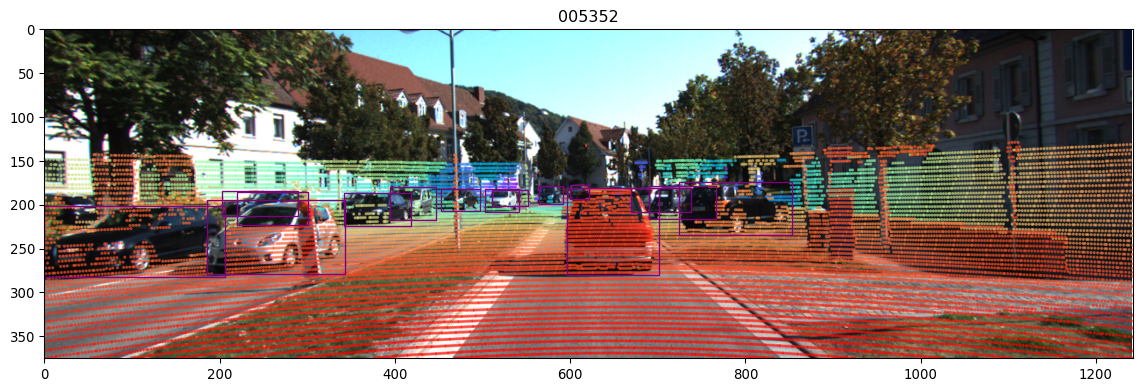

In [49]:
show_point_cloud_projected_without_intersections(2527)
show_point_cloud_projected_without_intersections(3695)
show_point_cloud_projected_without_intersections(5352)

In [50]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27306   5983   7         Car       0.00       2.0  -1.71  678.38  179.02   
27307   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27308   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27309   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27310   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27306  765.40  234.72    1.32   1.70    4.04   2.84  1.50  19.37 -1.57   
27307  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27308  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27309   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27310   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27306  19.634472         55.70        87.02       0.14   
27307  25.510956         48.09        57.82       0.11   
27308  43.498770         24.21        31.43       0.06   
27309  13.748476        101.47        95.57      -0.72   
27310  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
0                         False                 False        12.379818   
1                         False                 False        56.809068   
2                         False                 False        45.755852   
3                         False                 False        33.731449   
4                         False                 False        12.274350   
...                         ...                   ...              ...   
27306                     False                 False        14.164619   
27307                     False                 False        23.735048   
27308                     False                 False        41.656746   
27309                      True                 False         7.588763   
27310                      True                 False         7.756164   

       distance_error  distance_approx_2  distance_error_2  difficulty  
0           -3.646285          12.379818         -3.646285           0  
1            4.018829          56.809068          4.018829           3  
2            0.332282          45.755852          0.332282           3  
3            0.869848          33.731449          0.869848           1  
4            1.098417          12.274350          1.098417           0  
...               ...                ...               ...         ...  
27306        5.469853          20.092260         -0.457788           2  
27307        1.775908          40.0

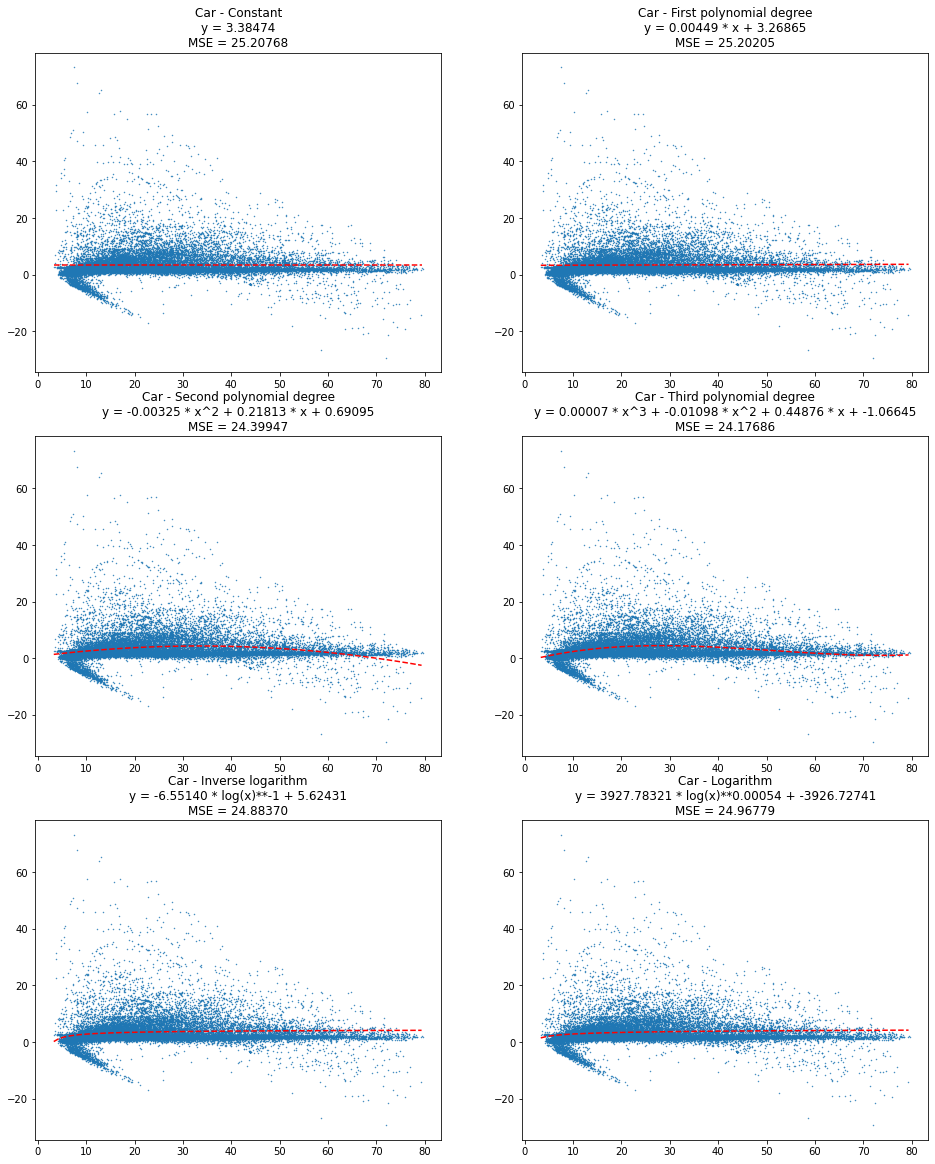

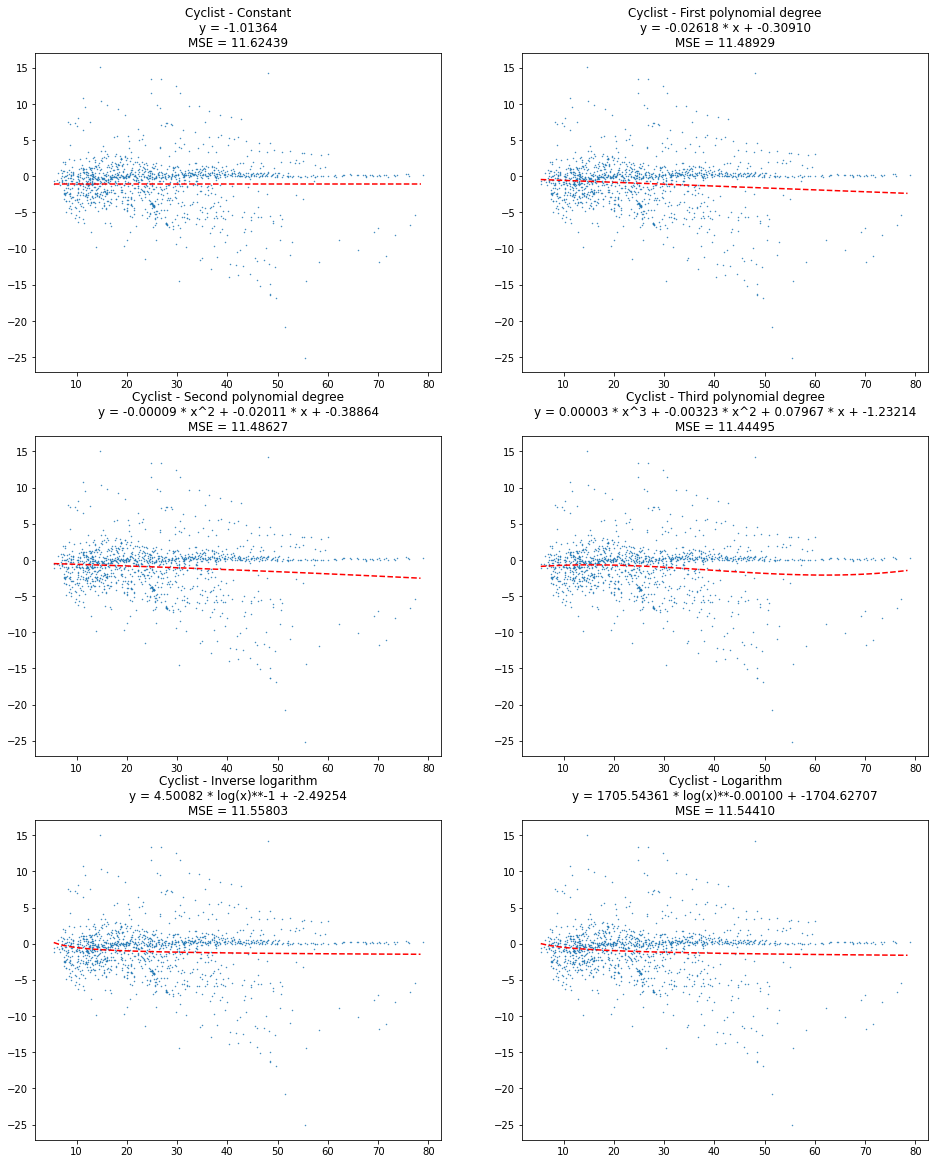

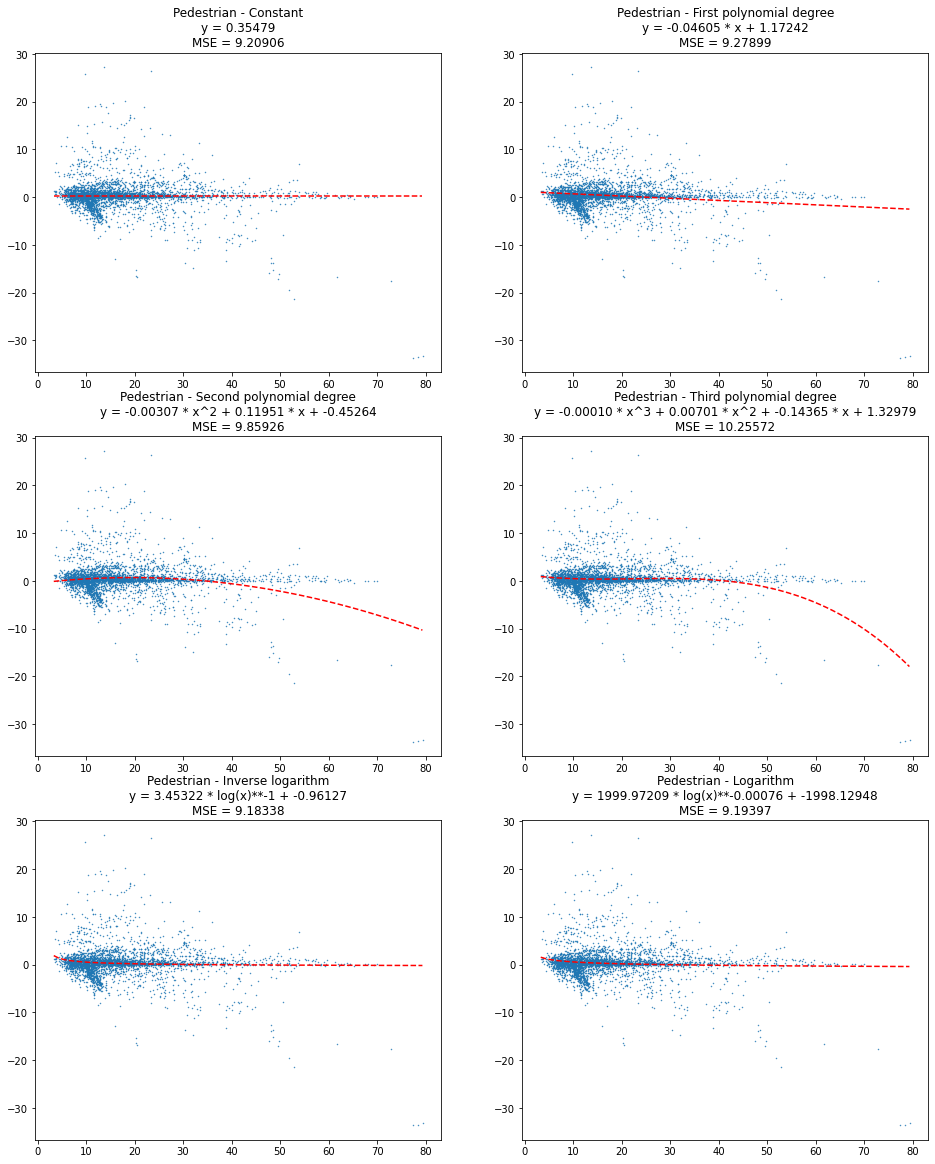

In [92]:
def objective_const(x, a):
    return a

def objective_f(x, a, b):
    return a * x + b

def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_log_1f(x, a, b):
    return a * np.log(x)**-1 + b 

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c
    
functions = [objective_const, objective_f, objective_2f, objective_3f, objective_log_1f, objective_log_f]
titles = ['%s - Constant\ny = %.5f\nMSE = %.5f',
          '%s - First polynomial degree\ny = %.5f * x + %.5f\nMSE = %.5f',
          '%s - Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
          '%s - Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
          '%s - Inverse logarithm\ny = %.5f * log(x)**-1 + %.5f\nMSE = %.5f',
          '%s - Logarithm\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f']

jump = 2
start = 5
end = 68
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx']) & \
                                        (df_train['distance_approx'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    
    plt.figure(figsize=(16, 20))
    
    for i in range(len(functions)):

        df_train_class = df_train[df_train['type'] == class_name]
        df_val_class = df_val[df_val['type'] == class_name]

        Y_to_show = q_0_5
        X_to_show = np.array(list(range(start,end,jump)))+jump/2

        Y = df_train_class['distance_error']
        X = df_train_class['distance_approx']

        Y_to_predict = df_val_class['distance_error'].values
        X_to_predict = df_val_class['distance_approx'].values
        
        function = functions[i]
        plt.subplot(3, 2, i+1)
        popt, _ = curve_fit(function, X, Y, maxfev = 10000)
        plt.scatter(X, Y, s=0.2)
        X_line = np.arange(min(X), max(X), 1)
        Y_line = list(map(lambda x: functions[i](x, *popt), X_line))
        #Y_line = function(X_line, *popt)
        plt.plot(X_line, Y_line, '--', color='red')
        Y_pred = function(X_to_predict, *popt)
        if type(Y_pred) != np.ndarray:
            Y_pred = [Y_pred]*len(Y_to_predict)
        mse = mean_squared_error(Y_to_predict, Y_pred)
        plt.title(titles[i] % (class_name, *popt, mse))
    plt.show()

Car - Third polynomial degree\
Cyclist - First polynomial degree\
Pedestrian - Constant -> 0

In [93]:
def objective_0(x):
    return 0

popt_car = None
popt_cyclist = None
popt_pedestrian = None

for class_name in ["Car","Cyclist","Pedestrian"]:

    df_train_class = df_train[df_train['type'] == class_name]
    
    Y = df_train_class['distance_error']
    X = df_train_class['distance_approx']
    
    popt, _ = curve_fit(objective_f, X, Y, maxfev = 1000)
    if class_name == "Cyclist":
        popt_cyclist = popt
        
    if class_name == "Pedestrian":
        popt_pedestrian = []
        
    popt, _ = curve_fit(objective_3f, X, Y, maxfev = 1000)
    if class_name == "Car":
        popt_car = popt

In [95]:
class Regression_model:
    def __init__(self, function, variables):
        self.function = function
        self.variables = variables
    def __str__(self):
        return "function = %s, variables = %s"%(self.function, self.variables)

class Regression_model_class:
    def __init__(self, model_car, model_pedestrian, model_cyclist):
        self.car = model_car
        self.pedestrian = model_pedestrian
        self.cyclist = model_cyclist
    def __str__(self):
        return "car: {%s} \npedestrian: {%s} \ncyclist: {%s}\n"%(self.car, self.pedestrian, self.cyclist)
        
class Regression_model_bb:
    def __init__(self, bb_complete, bb_incomplete):
        self.bb_complete = bb_complete
        self.bb_incomplete = bb_incomplete
    def __str__(self):
        return "bb_complete: {%s},\nbb_incomplete: {%s}\n"%(self.bb_complete, self.bb_incomplete)

In [98]:
pc_proj_refinement_model = Regression_model_class(Regression_model(objective_3f, popt_car),
                                                  Regression_model(objective_0, popt_pedestrian),
                                                  Regression_model(objective_f, popt_cyclist))
print(pc_proj_refinement_model)

car: {function = <function objective_3f at 0x7f6d19e27ae8>, variables = [ 7.15935510e-05 -1.09793561e-02  4.48755047e-01 -1.06645317e+00]} 
pedestrian: {function = <function objective_0 at 0x7f6d1e6ece18>, variables = []} 
cyclist: {function = <function objective_f at 0x7f6d19e27ea0>, variables = [-0.02618416 -0.30909785]}



In [99]:
with open('pc_proj_refinement_model.pkl', 'wb') as f:
    f.write(pickle.dumps(pc_proj_refinement_model))

## MSE of the distance with the 2nd method by KITTI difficulties and classes applying distance rectification

In [69]:
def get_types(image_id):
    df_frame = df[df['frame'] == image_id]
    types = list(df_frame['type'])
    return types

In [70]:
def approximate_distance(image_id, model):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = get_types(image_id)
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
   
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                               not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        types = list(enumerate(types))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        types.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        types = list(map(lambda x: x[1], types))
        
    # Create output dict
    bbs_distance = {'frame':[image_id]*len(types),
                    'left':list(map(lambda x: x[0], bbs)),
                    'top':list(map(lambda x: x[1], bbs)),
                    'right':list(map(lambda x: x[2], bbs)),
                    'bottom':list(map(lambda x: x[3], bbs)),
                    'type':types,
                    'distance':[]}
    
    # Iterate over bb
    for type_name, bb in zip(types, bbs):
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            # Approximate distance
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            height = bb[3] - bb[1] # bottom - top
            if type_name == 'Car':
                f = model.car.function
                rectification = f(distance, *model.car.variables)
                distance += rectification
            elif type_name == 'Pedestrian':
                f = model.pedestrian.function
                rectification = f(distance, *model.pedestrian.variables)
                distance += rectification
            elif type_name == 'Cyclist':
                f = model.cyclist.function
                rectification = f(distance, *model.cyclist.variables)
                distance += rectification
            else:
                print("Type must be Car, Pedestrian or Cyclist")
            
            bbs_distance['distance'].append(distance)
        else:
            bbs_distance['distance'].append(None)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [71]:
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
distance_approx = {'frame':[], 'left':[], 'top':[], 'right':[], 'bottom':[], 'type':[], 'distance':[]}
for frame in df['frame'].unique():
    frame_approx = approximate_distance(frame, pc_proj_refinement_model)
    dict_items = ['frame','left','top','right','bottom','type','distance']
    for item in dict_items:
        distance_approx[item].extend(frame_approx[item])
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = dict_items[:-1]+['distance_approx_rect_1'],
                         data = list(zip(distance_approx['frame'], distance_approx['left'],
                                         distance_approx['top'], distance_approx['right'],
                                         distance_approx['bottom'], distance_approx['type'],
                                         distance_approx['distance'])))

100%|█████████▉| 7477/7481 [02:39<00:00, 47.26it/s]

In [72]:
df_approx = df_approx.dropna()

In [73]:
df_approx

frame    left     top   right  bottom        type  \
0          0  712.40  143.00  810.73  307.92  Pedestrian   
1          1  676.60  163.95  688.98  193.93     Cyclist   
2          1  387.63  181.54  423.81  203.12         Car   
3          2  657.39  190.13  700.07  223.39         Car   
4          3  614.24  181.78  727.31  284.77         Car   
...      ...     ...     ...     ...     ...         ...   
34851   7480  501.01  178.40  523.53  228.03     Cyclist   
34852   7480  344.07  180.05  479.10  224.15         Car   
34853   7480  382.70  179.71  495.48  219.10         Car   
34854   7480  631.71  179.85  678.40  214.37         Car   
34855   7480  619.92  176.90  647.01  199.92         Car   

       distance_approx_rect_1  
0                   12.734607  
1                   44.248675  
2                   58.928456  
3                   38.057486  
4                   15.194321  
...                       ...  
34851               23.263417  
34852               29.638311  
34853               34.013135  
34854               34.715410  
34855               49.401482  

[34012 rows x 7 columns]

In [74]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])

In [75]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27306   5983   7         Car       0.00       2.0  -1.71  678.38  179.02   
27307   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27308   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27309   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27310   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27306  765.40  234.72    1.32   1.70    4.04   2.84  1.50  19.37 -1.57   
27307  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27308  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27309   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27310   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27306  19.634472         55.70        87.02       0.14   
27307  25.510956         48.09        57.82       0.11   
27308  43.498770         24.21        31.43       0.06   
27309  13.748476        101.47        95.57      -0.72   
27310  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
0                         False                 False        12.379818   
1                         False                 False        56.809068   
2                         False                 False        45.755852   
3                         False                 False        33.731449   
4                         False                 False        12.274350   
...                         ...                   ...              ...   
27306                     False                 False        14.164619   
27307                     False                 False        23.735048   
27308                     False                 False        41.656746   
27309                      True                 False         7.588763   
27310                      True                 False         7.756164   

       distance_error  distance_approx_2  distance_error_2  difficulty  \
0           -3.646285          12.379818         -3.646285           0   
1            4.018829          56.809068          4.018829           3   
2            0.332282          45.755852          0.332282           3   
3            0.869848          33.731449          0.869848           1   
4            1.098417          12.274350          1.098417           0   
...               ...                ...               ...         ...   
27306        5.469853          20.092260         -0.457788           2   
27307        1.775908      

In [76]:
difficulties = [0, 1, 2, 3]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard", "All"]

print("################################", end="\n\n")

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        start_time = time.time()
        mse = mean_squared_error(df_difficulty['distance'].tolist(),
                                 df_difficulty['distance_approx_rect_1'].tolist())
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mse))

    print("################################", end="\n\n")

################################

--- 0.0004513263702392578 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 5.822403717077922

--- 0.0004239082336425781 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 5.27087458854765

--- 0.00027751922607421875 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 5.98184726126154

################################

--- 0.0004961490631103516 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 13.477067350972499

--- 0.0002529621124267578 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 16.652728682708773

--- 0.0002961158752441406 seconds to calculate MSE, Moderate difficulty, Pedestrian class 

# Closest distance to distance to the center after removing outliers

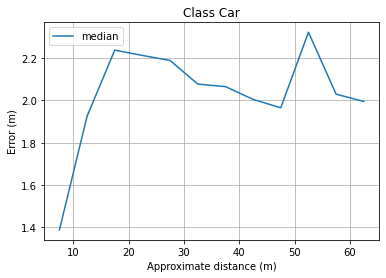

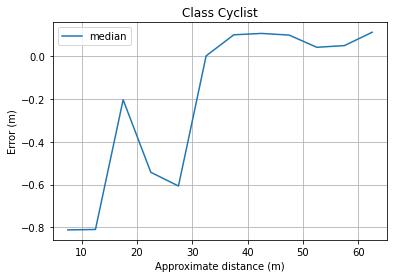

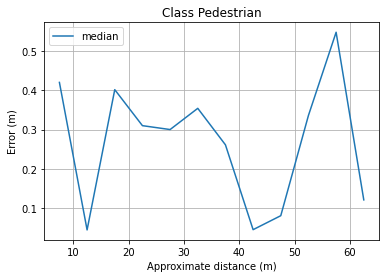

In [77]:
jump = 5
start = 5
end = 65
# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx']) & \
                                        (df_train['distance_approx'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))

    # Create plot
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_5)
    plt.legend(['median'])
    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')
    plt.grid()
    plt.show()

In [78]:
# Calculate regression curve of Car and Cyclist to rectify the approximation
jump = 5
start = 5
end = 65
dict_class_median = {'Car':[], 'Cyclist':[], 'Pedestrian':[]}
# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx']) & \
                                        (df_train['distance_approx'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    median = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    dict_class_median[class_name] = median

In [79]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6696   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6697   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6698   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6699   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6700   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6696  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6697  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6698  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6699  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6700  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
0                        False                 False        33.951394   
1                        False                 False        46.418030   
2                        False                 False        49.005706   
3                        False                 False        49.852558   
4                        False                 False        51.133280   
...                        ...                   ...              ...   
6696                     False                 False        15.919959   
6697                     False                 False        23.765591   
6698                     False                 False        25.429258   
6699                     False                 False        30.272493   
6700                     False                 False        45.628701   

      distance_error  difficulty  distance_approx_2  distance_error_2  \
0           1.282255           1          33.951394          1.282255   
1           0.850756           1          46.418030          0.850756   
2           1.840128           1          49.005706          1.840128   
3           2.859517           1          50.347864          2.364212   
4           2.450776           3          51.782106          1.801950   
...              ...         ...                ...               ...   
6696        3.856376           2          19.033945          0.742389   
6697        3.279255           1          25.222057          1.822789   
6698     

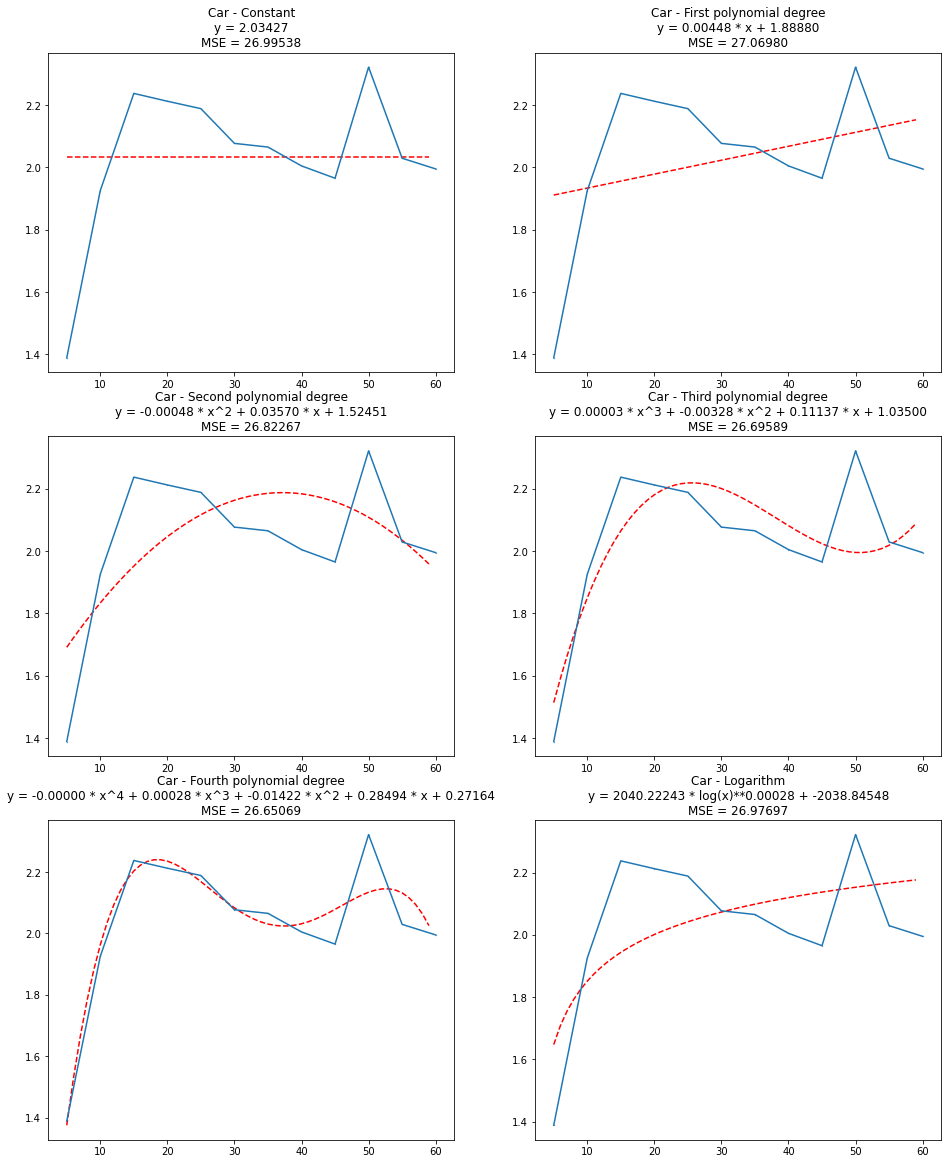

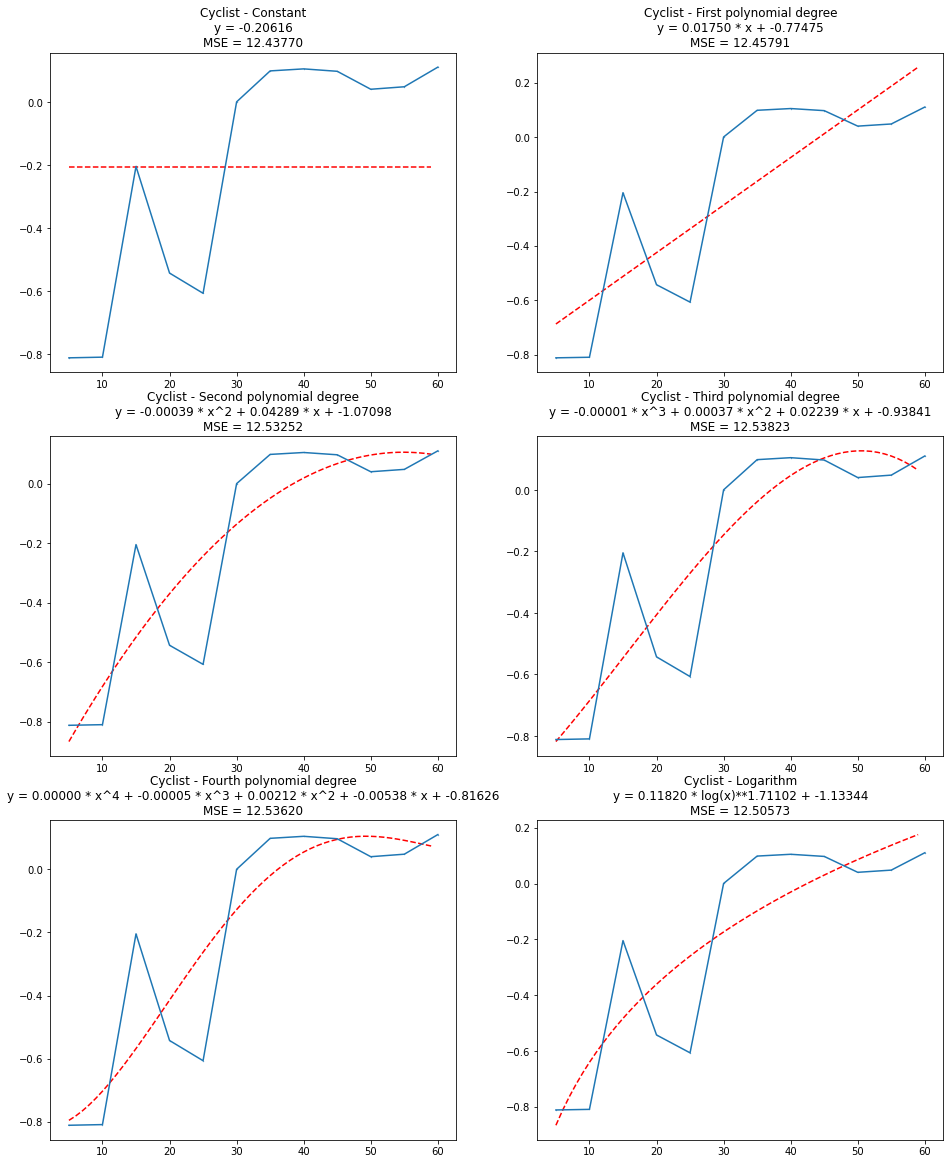

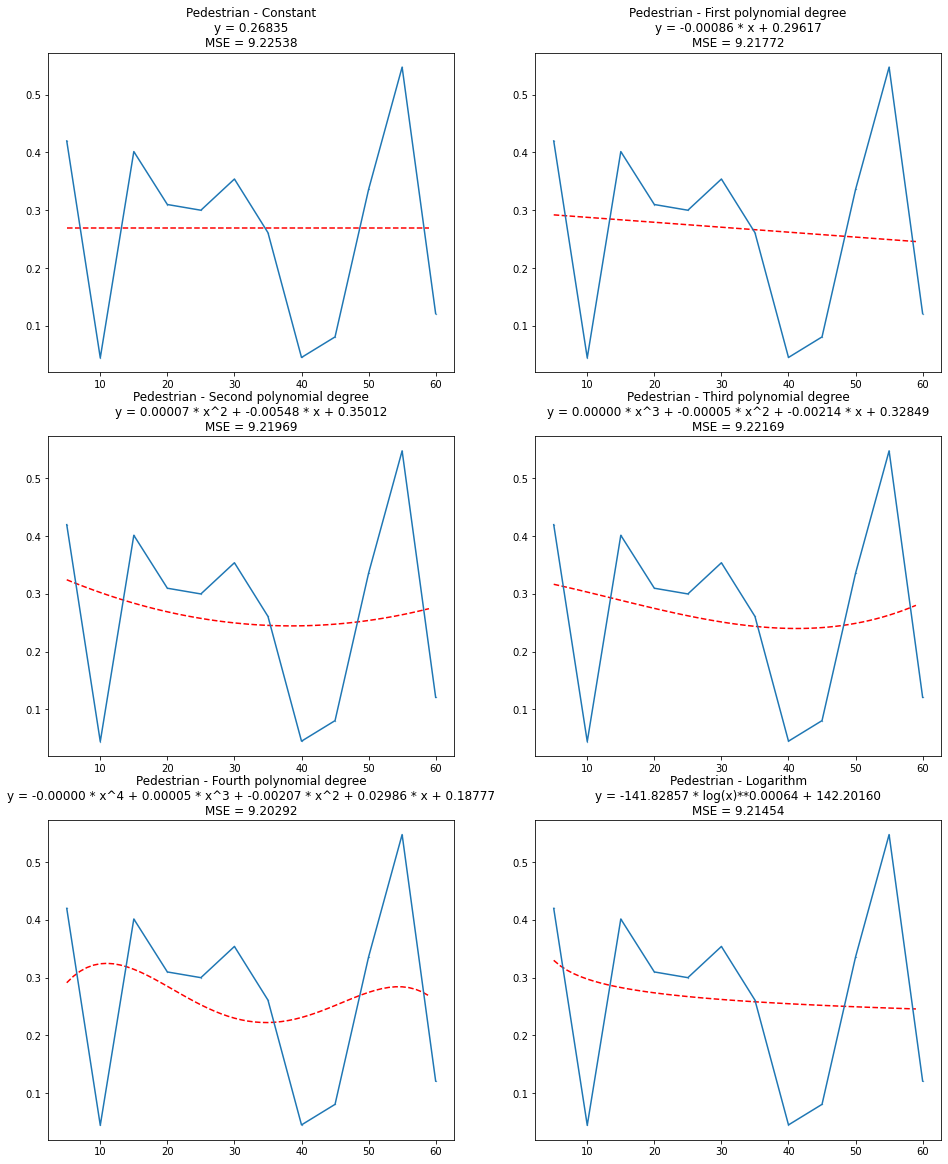

In [80]:
popt_car = None
popt_cyclist = None
popt_pedestrian = None

for class_name in ['Car', 'Cyclist', 'Pedestrian']:
    plt.figure(figsize=(16, 20))

    Y = dict_class_median[class_name]
    X = list(range(5,65,5))

    Y_val = df_val[df_val['type'] == class_name]
    Y_val = Y_val['distance']-Y_val['distance_approx'].values
    X_val = df_val[df_val['type'] == class_name]['distance_approx'].values

    def objective_const(x, a):
        return a

    def objective_f(x, a, b):
        return a * x + b

    def objective_2f(x, a, b, c):
        return a * x**2 + b * x + c

    def objective_3f(x, a, b, c, d):
        return a * x**3 + b * x**2 + c * x + d

    def objective_4f(x, a, b, c, d, e):
        return a * x**4 + b * x**3 + c * x**2 + d * x + e

    def objective_log_f(x, a, b, c):
        return a * np.log(x)**b + c 

    functions = [objective_const, objective_f, objective_2f, objective_3f, objective_4f, objective_log_f]
    titles = [class_name+' - Constant\ny = %.5f\nMSE = %.5f',
              class_name+' - First polynomial degree\ny = %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Fourth polynomial degree\ny = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Logarithm\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f']

    for i in range(6):
        plt.subplot(3, 2, i+1)
        function = functions[i]
        popt, _ = curve_fit(function, X, Y, maxfev = 100000)
        
        if class_name == 'Car' and functions[i] == objective_4f:
            popt_car = popt
        elif functions[i] == objective_const:
            if class_name == 'Pedestrian':
                popt_pedestrian = popt
            elif class_name == 'Cyclist':
                popt_cyclist = popt
            
        plt.scatter(X, Y, s=0.1)
        X_line = np.arange(min(X), max(X), 1)
        Y_line = list(map(lambda x: functions[i](x, *popt), X_line))
        plt.plot(X_line, Y_line, '--', color='red')
        Y_pred = function(X_val, *popt)
        if type(Y_pred) != np.ndarray:
            Y_pred = [Y_pred]*len(X_val)
        mse = mean_squared_error(Y_val, Y_pred)
        plt.plot(X, Y)
        plt.title(titles[i] % (*popt, mse))
    plt.show()

Fourth polynomial degree - Car\
Constant - Cyclist & Pedestrian

In [81]:
pc_proj_refinement_model = Regression_model_class(Regression_model(objective_4f, popt_car),
                                                  Regression_model(objective_const, popt_pedestrian),
                                                  Regression_model(objective_const, popt_cyclist))
print(pc_proj_refinement_model)

car: {function = <function objective_4f at 0x7f6d3fb03ae8>, variables = [-1.95734856e-06  2.83144411e-04 -1.42177548e-02  2.84943527e-01
  2.71637173e-01]} 
pedestrian: {function = <function objective_const at 0x7f6cf3c0b510>, variables = [0.26834564]} 
cyclist: {function = <function objective_const at 0x7f6cf3c0b510>, variables = [-0.20615659]}



In [82]:
#with open('pc_proj_refinement_model.pkl', 'wb') as f:
#    f.write(pickle.dumps(pc_proj_refinement_model))

100%|██████████| 7481/7481 [02:52<00:00, 47.26it/s]

## MSE of the distance with the 2nd method by KITTI difficulties and classes applying distance rectification without outliers.

In [83]:
def get_types(image_id):
    df_frame = df[df['frame'] == image_id]
    types = list(df_frame['type'])
    return types

In [84]:
def approximate_distance(image_id, model):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = df[df['frame'] == image_id]['type'].tolist()
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
    
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                        not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        types = list(enumerate(types))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        types.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        types = list(map(lambda x: x[1], types))
        
    # Create output dict
    bbs_distance = {'frame':[image_id]*len(types),
                    'left':list(map(lambda x: x[0], bbs)),
                    'top':list(map(lambda x: x[1], bbs)),
                    'right':list(map(lambda x: x[2], bbs)),
                    'bottom':list(map(lambda x: x[3], bbs)),
                    'type':types,
                    'distance':[]}
    
    # Iterate over bb
    for type_name, bb in zip(types, bbs):
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            # Approximate distance
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            height = bb[3] - bb[1] # bottom - top
            if type_name == 'Car':
                f = model.car.function
                rectification = f(distance, *model.car.variables)
                distance += rectification
            elif type_name == 'Pedestrian':
                f = model.pedestrian.function
                rectification = f(distance, *model.pedestrian.variables)
                distance += rectification
            elif type_name == 'Cyclist':
                f = model.cyclist.function
                rectification = f(distance, *model.cyclist.variables)
                distance += rectification
            else:
                print("Type must be Car, Pedestrian or Cyclist")
            
            bbs_distance['distance'].append(distance)
        else:
            bbs_distance['distance'].append(None)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [85]:
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
distance_approx = {'frame':[], 'left':[], 'top':[], 'right':[], 'bottom':[], 'type':[], 'distance':[]}
for frame in df['frame'].unique():
    frame_approx = approximate_distance(frame, pc_proj_refinement_model)
    dict_items = ['frame','left','top','right','bottom','type','distance']
    for item in dict_items:
        distance_approx[item].extend(frame_approx[item])
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = dict_items[:-1]+['distance_approx_rect_2'],
                         data = list(zip(distance_approx['frame'], distance_approx['left'],
                                         distance_approx['top'], distance_approx['right'],
                                         distance_approx['bottom'], distance_approx['type'],
                                         distance_approx['distance'])))

100%|█████████▉| 7480/7481 [02:42<00:00, 44.61it/s]

In [86]:
df_approx = df_approx[df_approx['distance_approx_rect_2'] != None]

In [87]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])

In [88]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6696   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6697   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6698   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6699   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6700   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6696  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6697  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6698  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6699  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6700  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx  \
0                        False                 False        33.951394   
1                        False                 False        46.418030   
2                        False                 False        49.005706   
3                        False                 False        49.852558   
4                        False                 False        51.133280   
...                        ...                   ...              ...   
6696                     False                 False        15.919959   
6697                     False                 False        23.765591   
6698                     False                 False        25.429258   
6699                     False                 False        30.272493   
6700                     False                 False        45.628701   

      distance_error  difficulty  distance_approx_2  distance_error_2  \
0           1.282255           1          33.951394          1.282255   
1           0.850756           1          46.418030          0.850756   
2           1.840128           1          49.005706          1.840128   
3           2.859517           1          50.347864          2.364212   
4           2.450776           3          51.782106          1.801950   
...              ...         ...                ...               ...   
6696        3.856376           2          19.033945          0.742389   
6697        3.279255           1          25.222057          1.822789   
6698     

In [89]:
difficulties = [0, 1, 2, 3]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard", "All"]

print("################################", end="\n\n")

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        start_time = time.time()
        mse = mean_squared_error(df_difficulty['distance'].tolist(),
                                 df_difficulty['distance_approx_rect_2'].tolist())
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mse))

    print("################################", end="\n\n")

################################

--- 0.0004706382751464844 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 2.363887418662573

--- 0.00023984909057617188 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 6.578889318036422

--- 0.0002608299255371094 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 5.855116211618467

################################

--- 0.0005538463592529297 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 10.722774603769858

--- 0.00023484230041503906 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 19.036301834595314

--- 0.0002696514129638672 seconds to calculate MSE, Moderate difficulty, Pedestrian cla

100%|██████████| 7481/7481 [02:58<00:00, 44.61it/s]